# Group: Jingmin Chen, Tianyu Sun

# Introduction

I'll explore the influence on variable selection and dimensionality reduction on linear model. At first I'll explore each feature in this dataset and determain their relationship. And then do variable selection or dimensionality reduction on them to obtain several subsets. Finally compare model performance on these subsets.

Here are some important steps:

1.  load data

2.  perform basic EDA and find relationship between each feature

3.  select variables which most related to response variable or perform dimensionality reduction

4.  train linear models on dataset

In [1]:
# import python libraries
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import pearsonr
import rfpimp

## Load data

Load data to `DataFrame` and check if there are invalid data.

Use mean value to fill invalid data entries.

And then change categorial data to one-hot code format.

Here are meanings of variables:

Attribute: Attribute Range

1. symboling: -3, -2, -1, 0, 1, 2, 3.
2. normalized-losses: continuous from 65 to 256.
3. make:
alfa-romero, audi, bmw, chevrolet, dodge, honda,
isuzu, jaguar, mazda, mercedes-benz, mercury,
mitsubishi, nissan, peugot, plymouth, porsche,
renault, saab, subaru, toyota, volkswagen, volvo
4. fuel-type: diesel, gas.
5. aspiration: std, turbo.
6. num-of-doors: four, two.
7. body-style: hardtop, wagon, sedan, hatchback, convertible.
8. drive-wheels: 4wd, fwd, rwd.
9. engine-location: front, rear.
10. wheel-base: continuous from 86.6 120.9.
11. length: continuous from 141.1 to 208.1.
12. width: continuous from 60.3 to 72.3.
13. height: continuous from 47.8 to 59.8.
14. curb-weight: continuous from 1488 to 4066.
15. engine-type: dohc, dohcv, l, ohc, ohcf, ohcv, rotor.
16. num-of-cylinders: eight, five, four, six, three, twelve, two.
17. engine-size: continuous from 61 to 326.
18. fuel-system: 1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi.
19. bore: continuous from 2.54 to 3.94.
20. stroke: continuous from 2.07 to 4.17.
21. compression-ratio: continuous from 7 to 23.
22. horsepower: continuous from 48 to 288.
23. peak-rpm: continuous from 4150 to 6600.
24. city-mpg: continuous from 13 to 49.
25. highway-mpg: continuous from 16 to 54.
26. price: continuous from 5118 to 45400.




Load data and clean data

In [16]:
# ignore warning
warnings.filterwarnings("ignore")
# load data and rename columns
data = pd.read_csv('https://raw.githubusercontent.com/TTZUO/DAV-6150/master/M4_Data.csv', header=None)
data.columns = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

# use mean to fill invalid data
data['normalized-losses'][data['normalized-losses'] == '?'] = None
data['normalized-losses'] = data['normalized-losses'].astype(np.float)
data['normalized-losses'] = data['normalized-losses'].fillna(data['normalized-losses'].mean())

data['bore'][data['bore'] == '?'] = None
data['bore'] = data['bore'].astype(np.float)
data['bore'] = data['bore'].fillna(data['bore'].mean())

data['horsepower'][data['horsepower'] == '?'] = None
data['horsepower'] = data['horsepower'].astype(np.float)
data['horsepower'] = data['horsepower'].fillna(data['horsepower'].mean())

data['peak-rpm'][data['peak-rpm'] == '?'] = None
data['peak-rpm'] = data['peak-rpm'].astype(np.float)
data['peak-rpm'] = data['peak-rpm'].fillna(data['peak-rpm'].mean())

data['price'][data['price'] == '?'] = None
data['price'] = data['price'].astype(np.float)
data['price'] = data['price'].fillna(data['price'].mean())

data['stroke'][data['stroke'] == '?'] = None
data['stroke'] = data['stroke'].astype(np.float)
data['stroke'] = data['stroke'].fillna(data['stroke'].mean())

data['num-of-doors'][data['num-of-doors'] == '?'] = 'four'




In [51]:
#check if there is null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 76 columns):
symboling                  205 non-null int64
normalized-losses          205 non-null float64
wheel-base                 205 non-null float64
length                     205 non-null float64
width                      205 non-null float64
height                     205 non-null float64
curb-weight                205 non-null int64
engine-size                205 non-null int64
bore                       205 non-null float64
stroke                     205 non-null float64
compression-ratio          205 non-null float64
horsepower                 205 non-null float64
peak-rpm                   205 non-null float64
city-mpg                   205 non-null int64
highway-mpg                205 non-null int64
price                      205 non-null float64
make_alfa-romero           205 non-null uint8
make_audi                  205 non-null uint8
make_bmw                   205 non-null uint8

## Basic EDA

Here some steps

1.  explore distribution of continuous variable
2.  explore relationship between continuous prediction variables and response variable
3.  explore relationship between variables

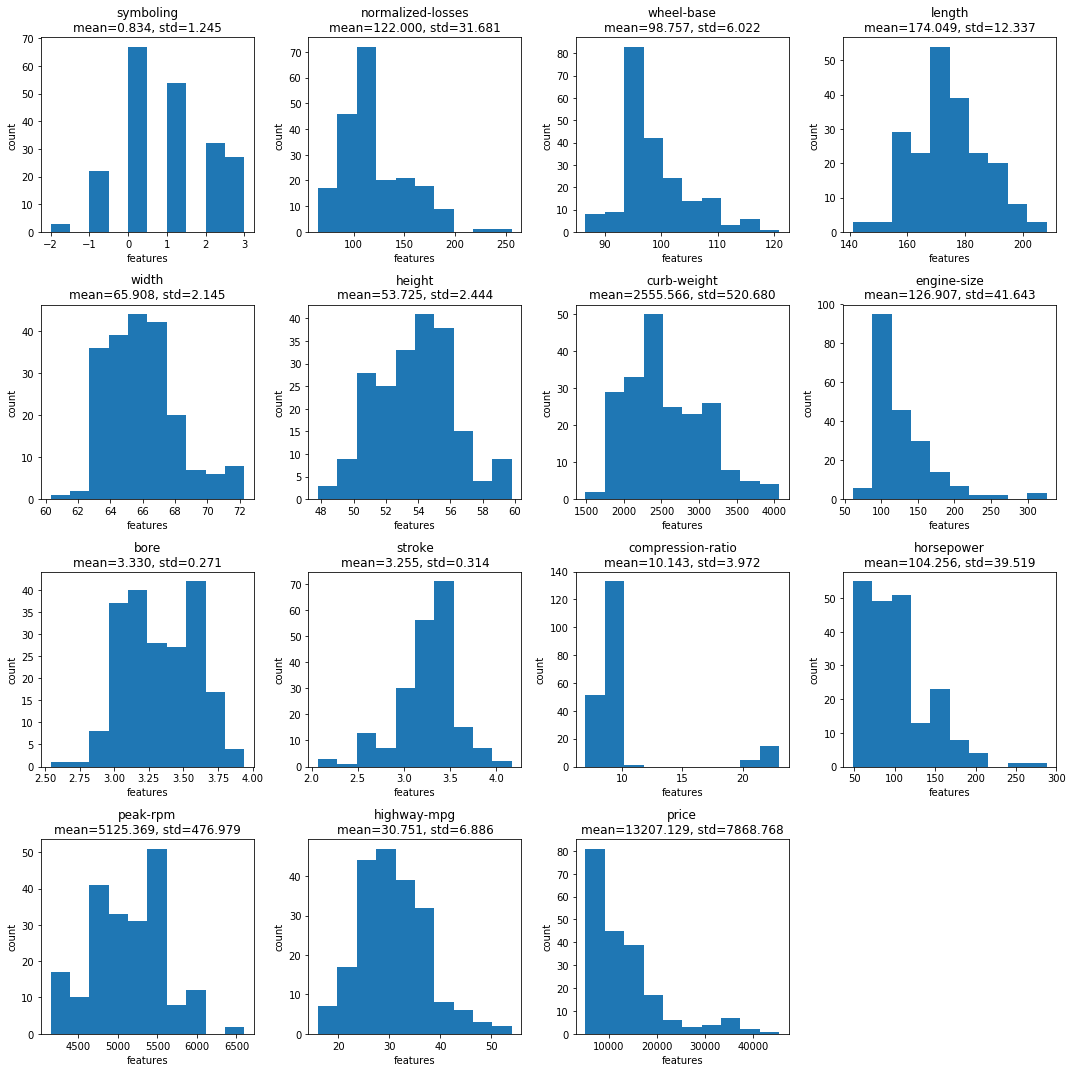

In [18]:
continuous_features = [
    'symboling',
    'normalized-losses',
    'wheel-base',
    'length',
    'width',
    'height',
    'curb-weight',
    'engine-size',
    'bore',
    'stroke',
    'compression-ratio',
    'horsepower',
    'peak-rpm',
    'highway-mpg',
    'price'
]


# plot histograms for each variable
i = 1
fig = plt.figure(figsize=(15, 15))
for features in continuous_features:

    if data[features].dtype != np.object:
        plt.subplot(4, 4, i)
        plt.hist(data[features])
        plt.xlabel('features')
        plt.ylabel('count')
        plt.title('{}\nmean={:.3f}, std={:.3f}'.format(features, data[features].mean(), data[features].std()))
        plt.tight_layout()
        
        i += 1
plt.show()

## Conclusion

Most variables obeying a normal distribution or a skewed normal distribution.

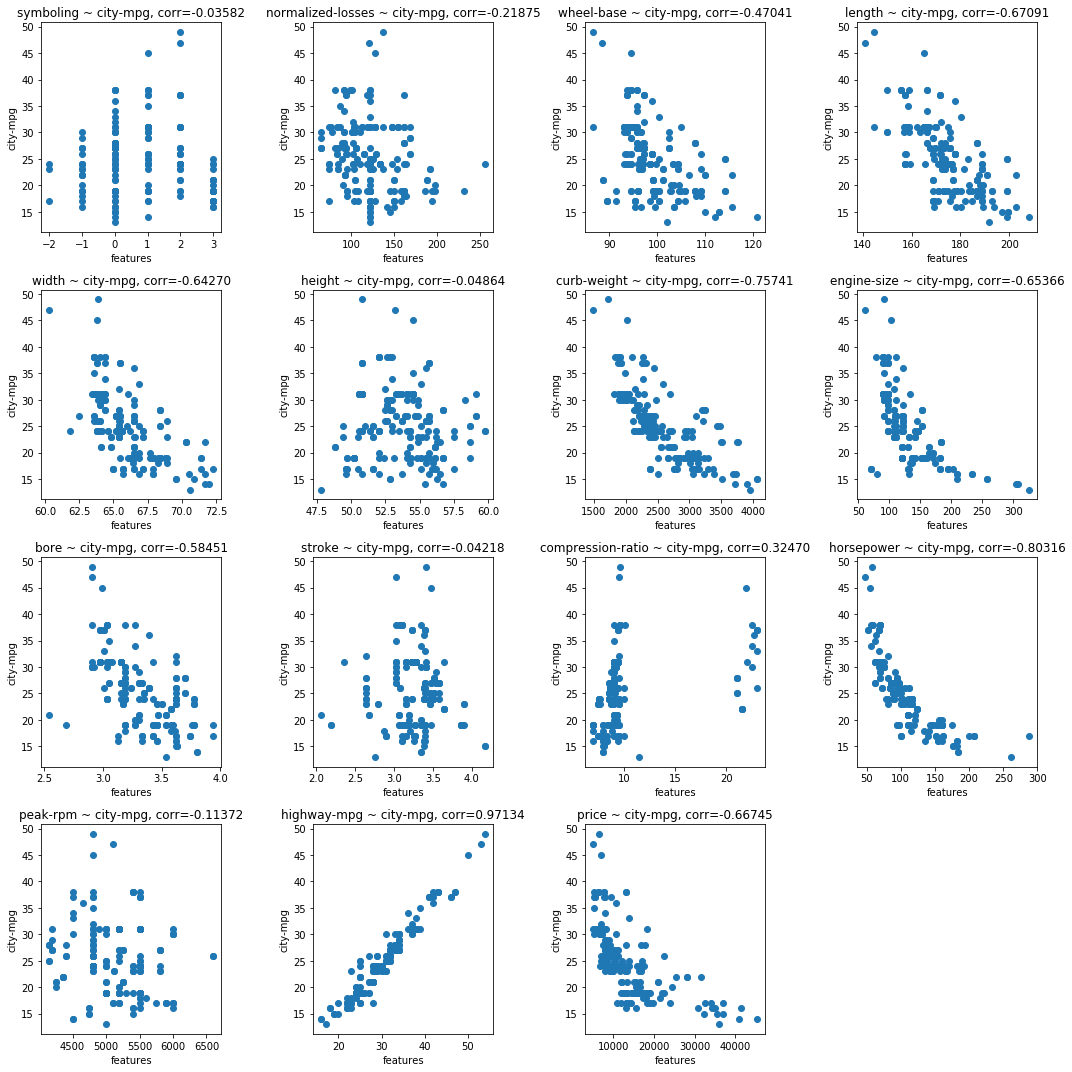

In [19]:
# relationship between continuous variables and response variable
continuous_features = [
    'symboling',
    'normalized-losses',
    'wheel-base',
    'length',
    'width',
    'height',
    'curb-weight',
    'engine-size',
    'bore',
    'stroke',
    'compression-ratio',
    'horsepower',
    'peak-rpm',
    'highway-mpg',
    'price'
]


i = 1
fig = plt.figure(figsize=(15, 15))
for features in continuous_features:
    

    if data[features].dtype != np.object:
        plt.subplot(4, 4, i)
        plt.plot(data[features], data['city-mpg'], 'o')
        plt.xlabel('features')
        plt.ylabel('city-mpg')
        plt.title('{} ~ city-mpg, corr={:.5f}'.format(features, data[[features, 'city-mpg']].corr(method='pearson').iloc[0, 1]))
        plt.tight_layout()
        
        i += 1
plt.show()

## Conclusion 

Some variables have a strong positive or negative relationship (pearson score greater then 0.5 or less then -0.5) with response variable while some are not.

#### Convert categorial variables to one-hot encode for further process

In [20]:
data = pd.get_dummies(data)

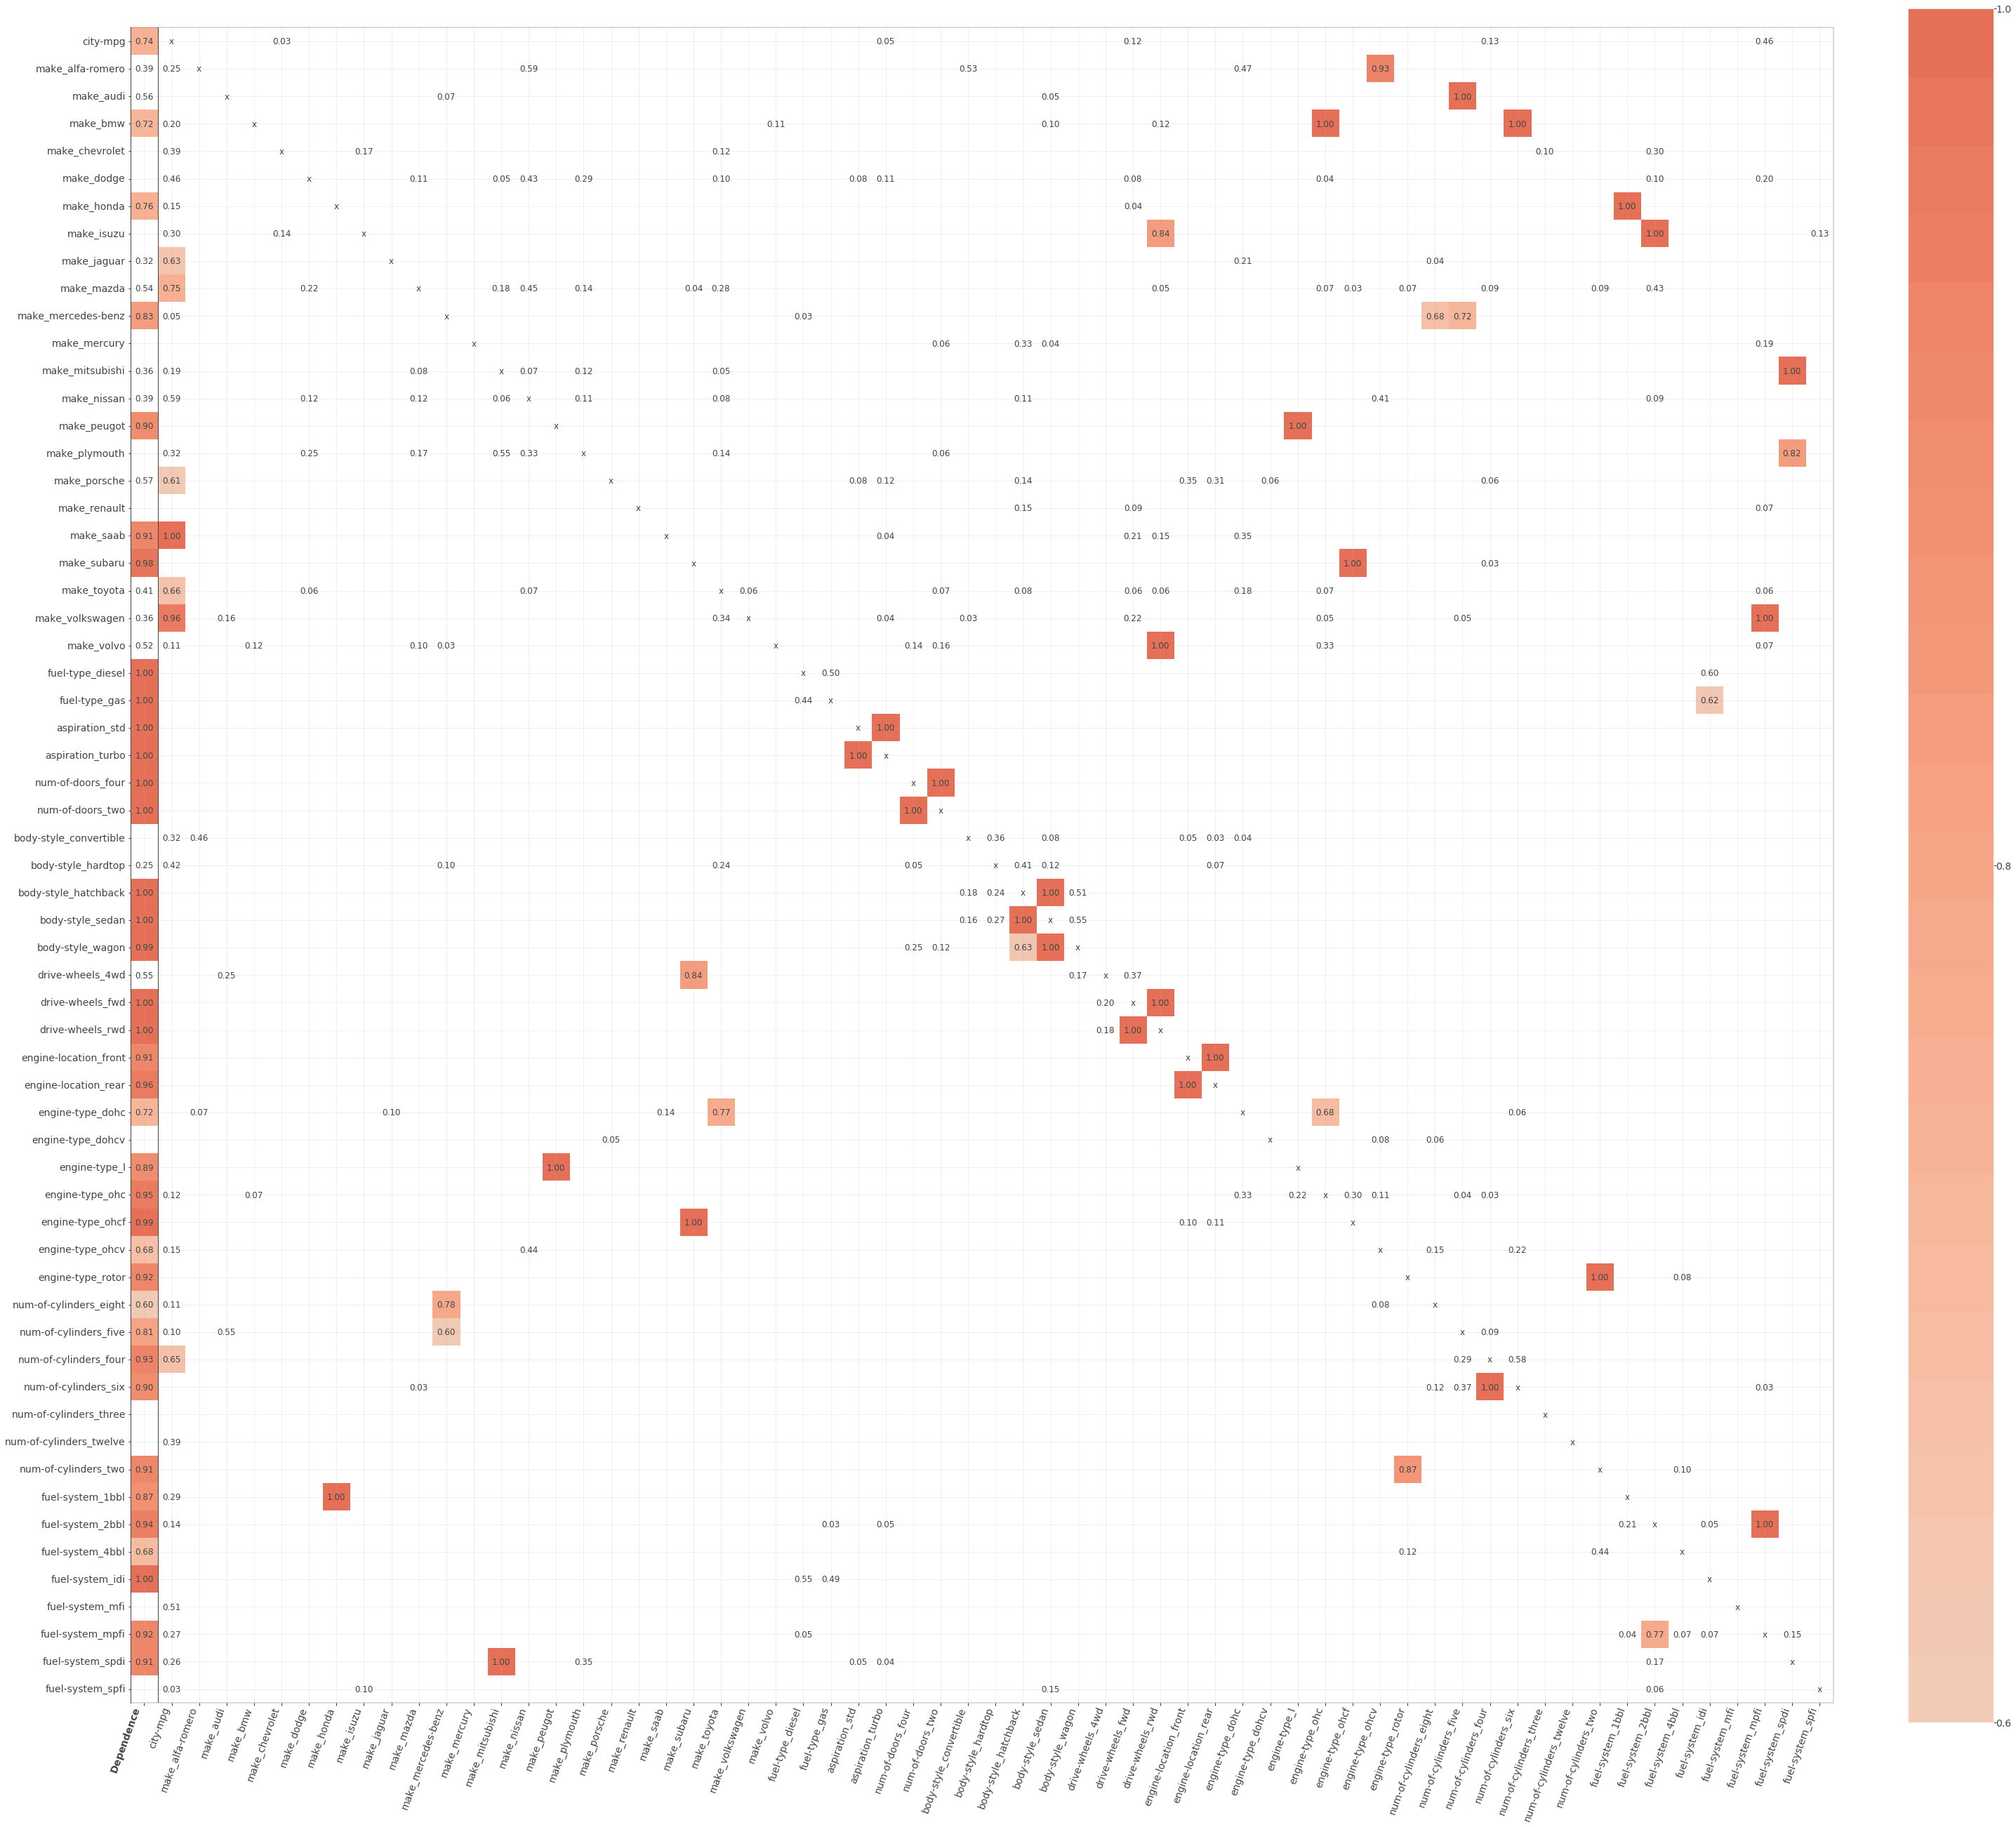

In [21]:

# relationship between categorial variables
categorial_features = list(data.columns)

for f in continuous_features:
    categorial_features.remove(f)

rfpimp.plot_dependence_heatmap(
    rfpimp.feature_dependence_matrix(data[categorial_features]),
    value_fontsize=12,
    label_fontsize=14,
    figsize=(40, 40)
)
fig = plt.gcf()

## Conclusion

Some categorial variables are related. It is obviously that sub-variables in one-hot encoding is strong related. So reduce variable number on them is necessary.

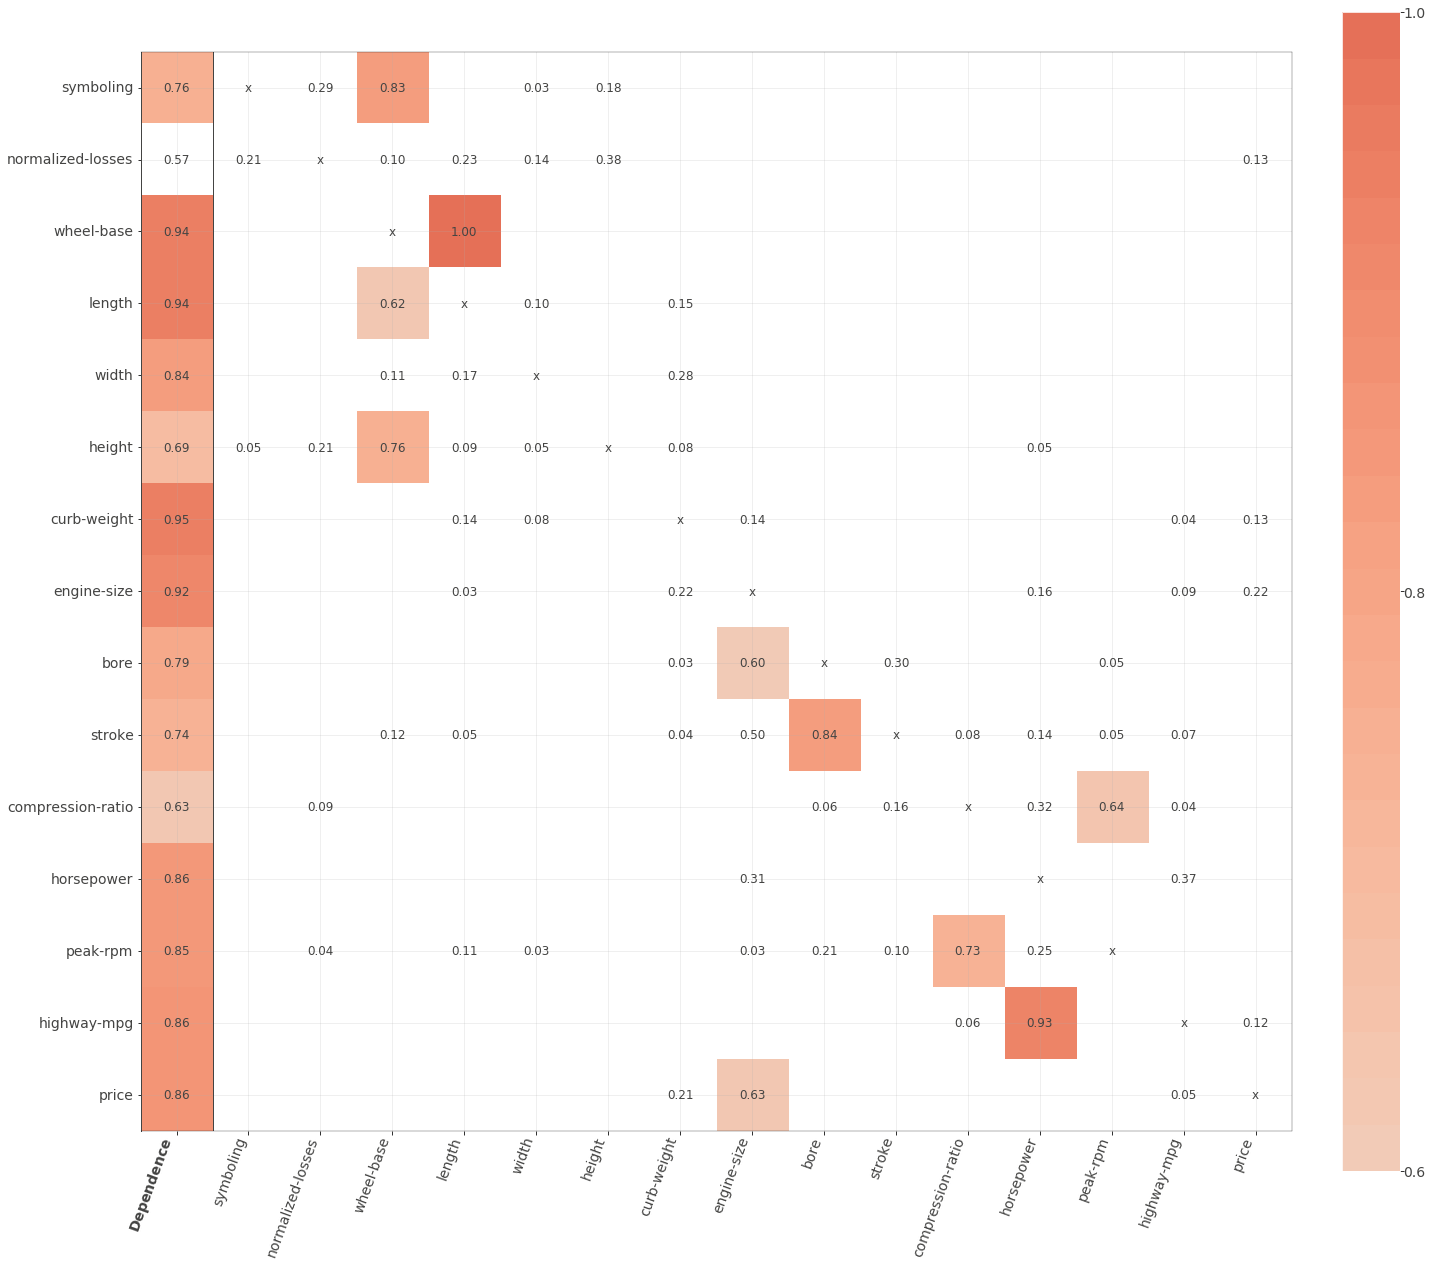

In [22]:

# relationship between continuous variables
rfpimp.plot_dependence_heatmap(
    rfpimp.feature_dependence_matrix(data[continuous_features]),
    value_fontsize=12,
    label_fontsize=14,
    figsize=(20, 20)
)
fig = plt.gcf()

## Conclusion

From the figures above, we can find some continuous variables have a strong relationship with response variable `city-mpg` and lots of categorial variables have realationship between each other, such as `num-of-wcylinders` and `engine-size`. So it is necessary to do dimensionality reduction on them.

## Variable selection and dimensionality reduction

I'll perform variable selection and dimensionality reduction on this dataset.

I'll run 3 linear models.

1.  run on origin dataset

2.  run on dataset with dimensionality reduced by PCA

3.  run on dataset with variable selection (by backward selection strategy)

I'll use pearson score to judge which variable will be removed, which is equal to judge on p-value.

In [23]:
# backward selection 
def backward_selection(data, y, attr_list):

    i = 0
    attr = attr_list[0]
    # record final result
    rec = (np.inf, None)
    # set end criterion to pearson score greater then 0.8
    while attr[1] < 0.8:
        # remaining attrs
        attrs = attr_list[i:]
        # a new model
        model = LinearRegression()

        # selected features
        features = [item[0] for item in attrs]
        X = data[features].values
        score = cross_val_score(model, X, y, cv=k, scoring=make_scorer(mean_squared_error))
        print('mse on model, remove {:>3} attrs: {}'.format(i, score.mean()))

        # record best rsult
        if (score.mean() < rec[0]):
            rec = (score.mean(), features)

        i += 1
        attr = attr_list[i]
    return rec



In [24]:
continuous_features = [
    'symboling',
    'normalized-losses',
    'wheel-base',
    'length',
    'width',
    'height',
    'curb-weight',
    'engine-size',
    'bore',
    'stroke',
    'compression-ratio',
    'horsepower',
    'peak-rpm',
    'highway-mpg',
    'price'
]

categorial_features = list(data.columns)
categorial_features.remove('city-mpg')
for f in continuous_features:
    categorial_features.remove(f)

# continuous_features_list = []
# for f in continuous_features:
#     continuous_features_list.append((f, pearsonr(data[f], data['city-mpg'])[0]))

# continuous_features_list = sorted(continuous_features_list, key=lambda x: abs(x[1]))

# collect all features and sort them by pearson score
all_features = list(data.columns)
all_features.remove('city-mpg')
all_features_list = []
for f in all_features:
    all_features_list.append((f, pearsonr(data[f], data['city-mpg'])[0]))
all_features_list = sorted(all_features_list, key = lambda x: abs(x[1]))

# n_components for PCA
pca_p = 0.5

# response variable
y = data['city-mpg'].values

# k-fold cross validation
k = 5




In [47]:
# model running on origin dataset
dataset1 = data.copy()[categorial_features + continuous_features].values
model1 = LinearRegression()
score = cross_val_score(model1, dataset1, y, cv=k, scoring=make_scorer(mean_squared_error))
print('mse on model 1: ', score.mean())

# model running on dimemtionality reduced dataset
dataset2 = data.copy()[categorial_features + continuous_features]
pca = PCA(n_components=pca_p)
dataset2 = pca.fit_transform(dataset2.values)

model2 = LinearRegression()
score = cross_val_score(model2, dataset2, y, cv=k, scoring=make_scorer(mean_squared_error))
print('mse on model 2: ', score.mean())

# print all result on variable selectoin process
# and find the best variable combination
print("\n----------- backward selection ---------------\n")
dataset3 = data.copy()[categorial_features + continuous_features]
best = backward_selection(dataset3, y, all_features_list)
print(best)

mse on model 1:  1.8606599381014987e+19
mse on model 2:  25.66660026250789

----------- backward selection ---------------

mse on model, remove   0 attrs: 4.435580722974851e+18
mse on model, remove   1 attrs: 1.732410765688128e+17
mse on model, remove   2 attrs: 3.398890234356523
mse on model, remove   3 attrs: 3.39889023436607
mse on model, remove   4 attrs: 3.4818127670870935
mse on model, remove   5 attrs: 1.9115090482951667e+18
mse on model, remove   6 attrs: 1.2453214911399528e+19
mse on model, remove   7 attrs: 1.463314433832562e+18
mse on model, remove   8 attrs: 3.46850995220669
mse on model, remove   9 attrs: 3.637116503341781
mse on model, remove  10 attrs: 3.590294164785136
mse on model, remove  11 attrs: 3.886741637994807e+17
mse on model, remove  12 attrs: 3.223493552781336
mse on model, remove  13 attrs: 1.051177415204324e+16
mse on model, remove  14 attrs: 1.0972193996485306e+19
mse on model, remove  15 attrs: 3.401801989403885
mse on model, remove  16 attrs: 3.46351406

In [50]:
# test accuracy use cross_val_score,and set cv = 5
X = data[['length','curb-weight','horsepower','highway-mpg']]
y = data['city-mpg']
model = LinearRegression()
print('accuracy: ',np.mean(cross_val_score(model, X, y, cv=5)))

accuracy:  0.9396192773621609


## Conclusion

The result above shows that we get a better model with dimensionality or variable selection. And we get the best variable combination as follow:
[`length`, `curb-weight`, `horsepower`, `highway-mpg`]

The model we get by dimensionality reduction and variable selection is better then full model, and model on variable selection is better then it on PCA.

The accuracy is 93.9%